# Imports

In [325]:
from model_builder import ModelBuilder
import random
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams["font.family"] = "Times New Roman"
import warnings
warnings.filterwarnings("ignore")

In [2]:
with open("config.json", "rb") as json_file:
    config = json.load(json_file)
config

{'becker': {'filename': 'beckerestimation_output_conversation_level.csv',
  'cols_to_ignore': ['conversation_num',
   'mean_pre_discussion_error',
   'mean_post_discussion_error',
   'mean_pre_discussion_error_pct',
   'mean_post_discussion_error_pct',
   'question',
   'chatrooms',
   'trial_indx']},
 'csop': {'filename': 'csop_output_conversation_level.csv',
  'cols_to_ignore': ['conversation_num',
   'batch_num',
   'round_num',
   'round_index',
   'task_index',
   'complexity',
   'type',
   'social_perceptiveness',
   'skill',
   'normalized_score',
   'zscore_score',
   'zscore_round_duration',
   'zscore_efficiency']},
 'csopII': {'filename': 'csopII_output_conversation_level.csv',
  'cols_to_ignore': ['conversation_num',
   'batch_num',
   'vis_img',
   'int_verb',
   'ort_img',
   'rep_man',
   'soc_pers',
   'team_size',
   'difficulty',
   'score',
   'duration',
   'efficiency',
   'timestamp']},
 'dat': {'filename': 'DAT_output_conversation_level.csv',
  'cols_to_ignore':

# Repeated k-Fold Cross Validation
For each model, fit it k (=10) times, and track all metrics, as well as interpretability, across all the repeats.
This gets us a less noisy estimate at our models' performance.

In [3]:
def repeated_kfold_cv(model, k = 10, seed = 19104):

    """
    Parameters:
    - model: The model we are doing k-fold CV for
    - k: the number of fols (defaults to 10)
    - seed: the random seed (defaults to 19104)

    @returns the following, pouplated with data from the k0=-fold CV:
    - train_metrics: a dataframe to store all the training metrics
    - test_metrics: a dataframe to store all the test set metrics (we will universally use a 80-20 train-test split)
    - shap_df: a dataframe to store the Shapley value summaries for each fold
    - shap_correlation_df: a dataframe to store how the Shapley values correlate with feature values for each fold
    """

    # Repeated k-fold cross-validation
    random.seed(seed) # set seed for reproducibility
    random_states_list = [random.randint(100, 1000000) for _ in range(k)] # create a bunch of different random states

    # Store metrics --- R^2, MAE, MSE
    metrics = ['r2', 'mae', 'mse', 'rmse']
    train_metrics = pd.DataFrame(columns=metrics)
    test_metrics = pd.DataFrame(columns=metrics)

    for i in range(len(random_states_list)):
        # store the model metrics for each iteration
        metrics = model.evaluate_model(model.baseline_model, val_size = 0.2, test_size = None, random_state = random_states_list[i], visualize_model = False)
        train_metrics = train_metrics.append(metrics['train'], ignore_index=True)
        test_metrics = test_metrics.append(metrics['val'], ignore_index=True)
    
        # store the shap summary for each iteration

        try:     
            shap_summary = model.shap_summary
            shap_df = pd.merge(shap_df, shap_summary[['feature', 'shap']], on='feature')
            shap_df.rename(columns={'shap': f'shap_{i+1}'}, inplace=True)
            shap_correlation_df = pd.merge(shap_correlation_df, shap_summary[['feature', 'correlation_btw_shap_and_feature_value']], on='feature')
            shap_correlation_df.rename(columns={'correlation_btw_shap_and_feature_value': f'cor_{i+1}'}, inplace=True)
        except NameError:
            # we haven't defined these yet; we're in the first iteration!
            # we have to do this becaus model.X does not show up until after the first case when evaluate_model is called
            shap_df = pd.DataFrame({'feature': model.X.columns})
            shap_correlation_df = pd.DataFrame({'feature': model.X.columns})

            shap_summary = model.shap_summary
            shap_df = pd.merge(shap_df, shap_summary[['feature', 'shap']], on='feature')
            shap_df.rename(columns={'shap': f'shap_{i+1}'}, inplace=True)
            shap_correlation_df = pd.merge(shap_correlation_df, shap_summary[['feature', 'correlation_btw_shap_and_feature_value']], on='feature')
            shap_correlation_df.rename(columns={'correlation_btw_shap_and_feature_value': f'cor_{i+1}'}, inplace=True)


    shap_df.set_index('feature', inplace=True)
    shap_correlation_df.set_index('feature', inplace=True)

    return(shap_df, shap_correlation_df, train_metrics, test_metrics)

In [109]:
def get_repeated_kfold_cv_summary(shap_df, shap_correlation_df, train_metrics, test_metrics):
    """
    Get the means of the repeated k-fold cross validation across all relevant metrics.
    """
    shap_means = shap_df.mean(axis=1).sort_values(ascending = False)
    shap_cor_means = shap_correlation_df.mean(axis=1).reindex(index = shap_means.index)
    train_means = train_metrics.mean()
    test_means = test_metrics.mean()

    return(shap_means, shap_cor_means, train_means, test_means)

In [331]:
time_points = ["50% of data", "80% of data", "100% of data"]

In [304]:
def plot_important_features_over_time(merged_df):
    # Transpose the DataFrame and sort by each time point
    top_features = merged_df.apply(lambda x: x.nlargest(5))

    non_na_feature = top_features.dropna()
    na_feature = top_features.loc[~top_features.index.isin(top_features.dropna().index)].fillna(0)

    # Plot a line chart to show how the top feature values change over time
    if(not non_na_feature.empty):
        ax = non_na_feature.T.plot(kind='line', marker='o', cmap=mpl.cm.Dark2, linewidth=3)
        na_feature.T.plot(kind='line', marker='o', linestyle='--', cmap=mpl.cm.Accent, linewidth=3, ax=ax)  # Use the same axis for dashed lines
    else:
        ax = na_feature.T.plot(kind='line', marker='o', linestyle='--', cmap=mpl.cm.Accent, linewidth=3)
    
    plt.ylabel('Importance (SHAP value)', size=14)
    plt.title('Top Feature Importance Over Time', fontsize=18, fontweight="bold")
    plt.xticks(range(len(time_points)), time_points, fontsize=14)
    plt.legend(loc='upper left', fontsize=12, bbox_to_anchor=(1.05, 1), bbox_transform=ax.transAxes)
    plt.show()

In [320]:
def plot_r2_and_mse_over_time(metrics, title):
    # Transpose the data for plotting
    transposed_data = metrics.T
    fig, ax1 = plt.subplots()

    plt.style.use({"figure.facecolor": "white", "axes.facecolor": "white"})

    # Create the left y-axis for R^2
    ax1.set_ylabel("R^2", fontsize=14)
    ax1.plot(time_points, transposed_data["r2"], label="R^2", color="cadetblue", marker="o", linewidth=3)
    ax1.tick_params(axis="y", size=14)

    # Create the right y-axis for MSE
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel("MSE", fontsize=14)
    ax2.plot(time_points, transposed_data["mse"], label="MSE", color="mediumorchid", marker="o", linewidth=3)
    ax2.tick_params(axis="y", size=14)

    #x-axis font size
    ax1.tick_params(axis="x", labelsize=14)

    # Combine the legends for both lines
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc="upper left")

    # Adjust layout
    plt.title(title, fontweight="bold", fontsize=18)
    plt.tight_layout()
    plt.show()

# Per-Task Baseline Models
This notebook contains the _baseline models_ for each task. This allows us to get a quick understanding of the predictive features for each task (separately).

The lists of models are:

(1) Random Forests for each task:
- Jury
- CSOP Blended (across two datasets)
- CSOP Train -> CSOP II split
- DAT
- Estimation (Becker + Gurcay datasets, blended)

(2) Early Cut-off Models (Train model only on the first X% of the messages, so that we avoid issues where the final stages of the discussion reveal the outcome)
- 50% (all datasets)
- 80% (all datasets)


# Jury

### Full Data (100)%

In [5]:
# Define the basic model
juries_model = ModelBuilder(dataset_names = ["juries"])
juries_model.select_target(target=["majority_pct"])
juries_model.define_model(model_type = 'rf')

In [6]:
# Call the Repeated k-Fold CV
jury_shap, jury_shap_cor, jury_train_metrics, jury_test_metrics = repeated_kfold_cv(juries_model)
jury_shap_means, jury_shap_cor_means, jury_train_means, jury_test_means = get_repeated_kfold_cv_summary(jury_shap, jury_shap_cor, jury_train_metrics, jury_test_metrics)

Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done


### 80% Data

In [11]:
juries_model80 = ModelBuilder(dataset_names = ["juries"], output_dir = '../output/first_80/')
juries_model80.select_target(target=["majority_pct"])
juries_model80.define_model(model_type = 'rf')

In [12]:
jury_shap80, jury_shap_cor80, jury_train_metrics80, jury_test_metrics80 = repeated_kfold_cv(juries_model80)
jury_shap_means80, jury_shap_cor_means80, jury_train_means80, jury_test_means80 = get_repeated_kfold_cv_summary(jury_shap80, jury_shap_cor80, jury_train_metrics80, jury_test_metrics80)

Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done


### 50% Data

In [36]:
juries_model50 = ModelBuilder(dataset_names = ["juries"], output_dir = '../output/first_50/')
juries_model50.select_target(target=["majority_pct"])
juries_model50.define_model(model_type = 'rf')

In [14]:
jury_shap50, jury_shap_cor50, jury_train_metrics50, jury_test_metrics50 = repeated_kfold_cv(juries_model50)
jury_shap_means50, jury_shap_cor_means50, jury_train_means50, jury_test_means50 = get_repeated_kfold_cv_summary(jury_shap50, jury_shap_cor50, jury_train_metrics50, jury_test_metrics50)

Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done


### Combine Results for Juries

In [197]:
pd.concat([jury_test_means50, jury_test_means80, jury_test_means], keys = time_points, axis=1)
pd.concat([jury_shap_means50, jury_shap_means80, jury_shap_means], keys = time_points, axis=1).head(10)
pd.concat([jury_shap_cor_means50, jury_shap_cor_means80, jury_shap_cor_means], keys = time_points, axis=1).head(10)

,50% of Data,80% of Data,100% of Data
feature,,,
average_positivity_zscore_chats,0.670911,0.723697,0.733718
min_word_TTR,0.438879,0.231945,0.222428
average_verbs,-0.699502,-0.720773,-0.699445
average_insight,-0.741599,-0.576258,-0.361390
max_verbs,-0.693178,-0.634246,-0.711205
stdev_hedges,-0.828905,-0.797382,-0.822263
stdev_1st_person_start,-0.809547,-0.640417,-0.447442
average_dale_chall_score,-0.570780,-0.801978,-0.705056
max_time_diff,-0.790817,-0.466046,-0.474445


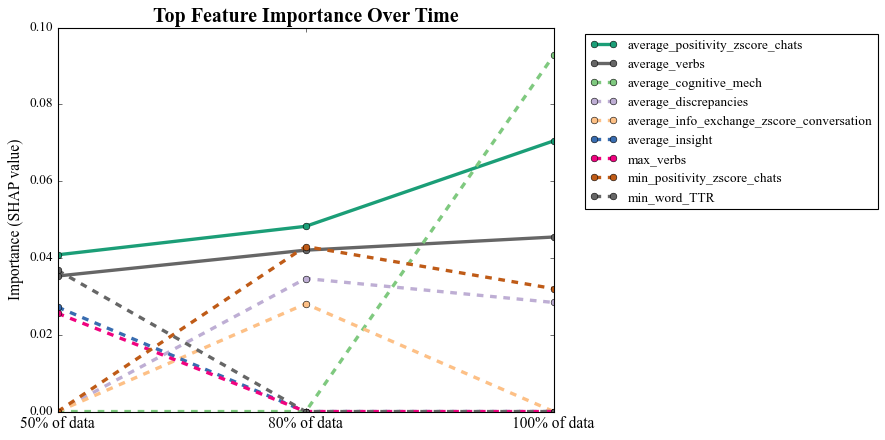

In [332]:
merged_df = pd.concat([jury_shap_means50, jury_shap_means80, jury_shap_means], keys = time_points, axis=1)
plot_important_features_over_time(merged_df)

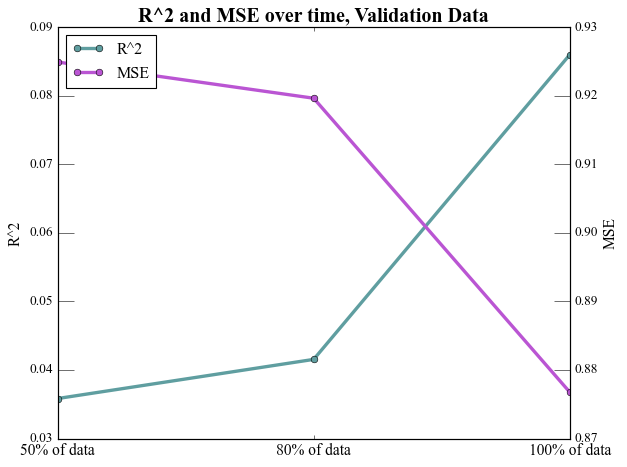

In [333]:
test_metrics = pd.concat([jury_test_means50, jury_test_means80, jury_test_means], keys = time_points, axis=1)
plot_r2_and_mse_over_time(test_metrics, "R^2 and MSE over time, Validation Data")

# CSOP (blended)

### Full Data (100%)

In [37]:
csop_blended_model = ModelBuilder(dataset_names = ["csop", "csopII"])
csop_blended_model.select_target(target=["zscore_efficiency", "efficiency"])
csop_blended_model.define_model(model_type = 'rf')

In [16]:
csop_shap, csop_shap_cor, csop_train_metrics, csop_test_metrics = repeated_kfold_cv(csop_blended_model)
csop_shap_means, csop_shap_cor_means, csop_train_means, csop_test_means = get_repeated_kfold_cv_summary(csop_shap, csop_shap_cor, csop_train_metrics, csop_test_metrics)

Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done


### 80% Data

In [38]:
csop_blended_model80 = ModelBuilder(dataset_names = ["csop", "csopII"], output_dir = '../output/first_80/')
csop_blended_model80.select_target(target=["zscore_efficiency", "efficiency"])
csop_blended_model80.define_model(model_type = 'rf')

In [18]:
csop_shap80, csop_shap_cor80, csop_train_metrics80, csop_test_metrics80 = repeated_kfold_cv(csop_blended_model80)
csop_shap_means80, csop_shap_cor_means80, csop_train_means80, csop_test_means80 = get_repeated_kfold_cv_summary(csop_shap80, csop_shap_cor80, csop_train_metrics80, csop_test_metrics80)

Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done


### 50% Data

In [39]:
csop_blended_model50 = ModelBuilder(dataset_names = ["csop", "csopII"], output_dir = '../output/first_50/')
csop_blended_model50.select_target(target=["zscore_efficiency", "efficiency"])
csop_blended_model50.define_model(model_type = 'rf')

In [20]:
csop_shap50, csop_shap_cor50, csop_train_metrics50, csop_test_metrics50 = repeated_kfold_cv(csop_blended_model50)
csop_shap_means50, csop_shap_cor_means50, csop_train_means50, csop_test_means50 = get_repeated_kfold_cv_summary(csop_shap50, csop_shap_cor50, csop_train_metrics50, csop_test_metrics50)

Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done


### Combine CSOP Blended Data

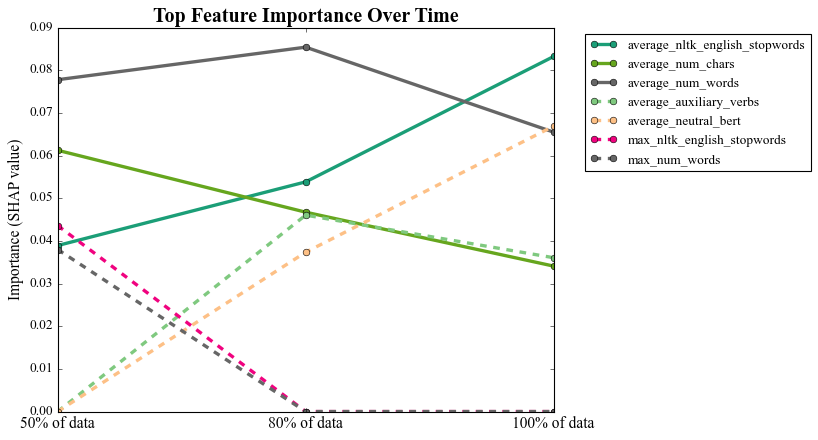

In [329]:
#csop_shap_means, csop_shap_cor_means, csop_train_means, csop_test_means

merged_df = pd.concat([csop_shap_means50, csop_shap_means80, csop_shap_means], keys = time_points, axis=1)
plot_important_features_over_time(merged_df)

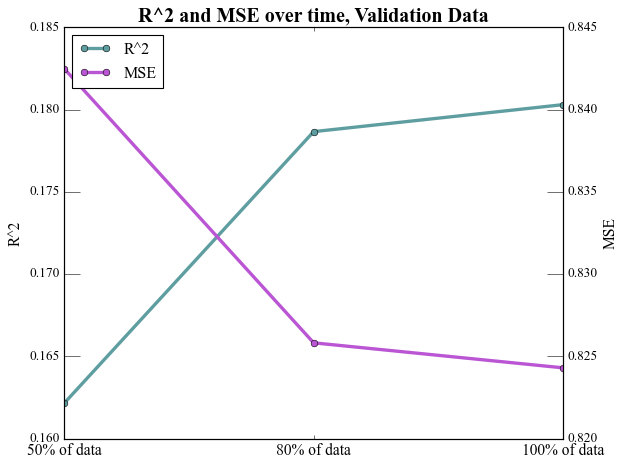

In [330]:
test_metrics = pd.concat([csop_test_means50, csop_test_means80, csop_test_means], keys = time_points, axis=1)
plot_r2_and_mse_over_time(test_metrics, "R^2 and MSE over time, Validation Data")

# CSOP (Train on CSOP I -> Test on CSOP II)

### Full Data (100%)

In [21]:
# csop_model = ModelBuilder(dataset_names = ["csop"], test_dataset_names=["csopII"])
# csop_model.select_target(target = "zscore_efficiency")
# csop_model.select_test_target(target = "efficiency")
# csop_model.define_model(model_type = 'rf')
# csop_model.evaluate_model(csop_model.baseline_model)

### 80% Data

In [22]:
# csop_model80 = ModelBuilder(dataset_names = ["csop"], test_dataset_names=["csopII"], output_dir = '../output/first_80/')
# csop_model80.select_target(target = "zscore_efficiency")
# csop_model80.select_test_target(target = "efficiency")
# csop_model80.define_model(model_type = 'rf')
# csop_model80.evaluate_model(csop_model80.baseline_model)

### 50% Data

In [23]:
# csop_model50 = ModelBuilder(dataset_names = ["csop"], test_dataset_names=["csopII"], output_dir = '../output/first_50/')
# csop_model50.select_target(target = "zscore_efficiency")
# csop_model50.select_test_target(target = "efficiency")
# csop_model50.define_model(model_type = 'rf')
# csop_model50.evaluate_model(csop_model50.baseline_model)

# DAT

### Full data (100%)

In [40]:
dat_model = ModelBuilder(dataset_names = ["dat"])
dat_model.select_target(target=["efficiency"])
dat_model.define_model(model_type = 'rf')

In [25]:
dat_shap, dat_shap_cor, dat_train_metrics, dat_test_metrics = repeated_kfold_cv(dat_model)
dat_shap_means, dat_shap_cor_means, dat_train_means, dat_test_means = get_repeated_kfold_cv_summary(dat_shap, dat_shap_cor, dat_train_metrics, dat_test_metrics)

Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done


### 80% Data

In [41]:
dat_model80 = ModelBuilder(dataset_names = ["dat"], output_dir = '../output/first_80/')
dat_model80.select_target(target=["efficiency"])
dat_model80.define_model(model_type = 'rf')

In [27]:
dat_shap80, dat_shap_cor80, dat_train_metrics80, dat_test_metrics80 = repeated_kfold_cv(dat_model80)
dat_shap_means80, dat_shap_cor_means80, dat_train_means80, dat_test_means80 = get_repeated_kfold_cv_summary(dat_shap80, dat_shap_cor80, dat_train_metrics80, dat_test_metrics80)

Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done


### 50% Data

In [42]:
dat_model50 = ModelBuilder(dataset_names = ["dat"], output_dir = '../output/first_50/')
dat_model50.select_target(target=["efficiency"])
dat_model50.define_model(model_type = 'rf')

In [29]:
dat_shap50, dat_shap_cor50, dat_train_metrics50, dat_test_metrics50 = repeated_kfold_cv(dat_model50)
dat_shap_means50, dat_shap_cor_means50, dat_train_means50, dat_test_means50 = get_repeated_kfold_cv_summary(dat_shap50, dat_shap_cor50, dat_train_metrics50, dat_test_metrics50)

Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done


### Combine DAT Results

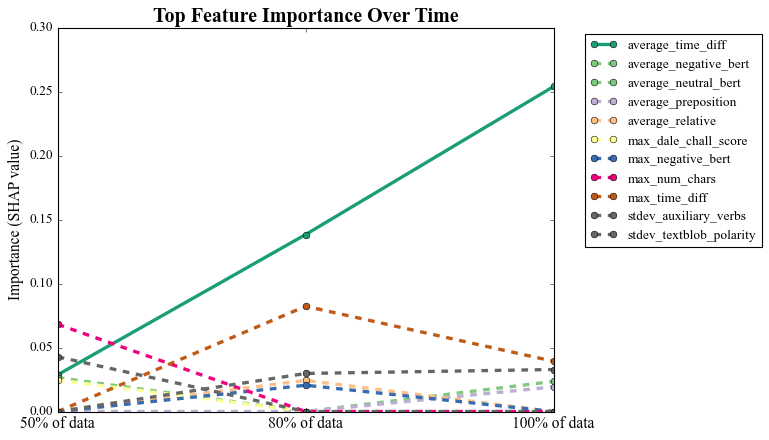

In [334]:
merged_df = pd.concat([dat_shap_means50, dat_shap_means80, dat_shap_means], keys = time_points, axis=1)
plot_important_features_over_time(merged_df)

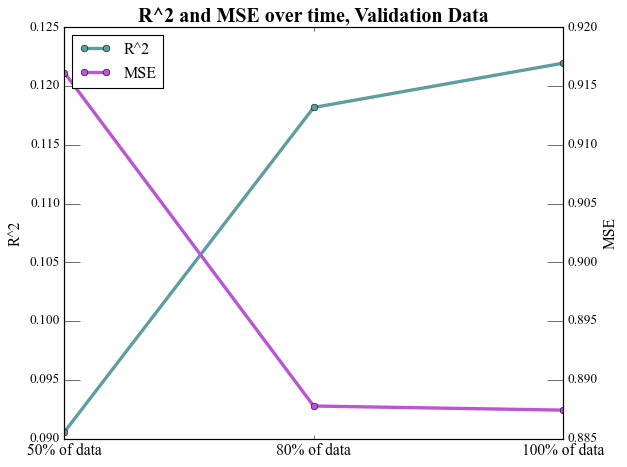

In [335]:
test_metrics = pd.concat([dat_test_means50, dat_test_means80, dat_test_means], keys = time_points, axis=1)
plot_r2_and_mse_over_time(test_metrics, "R^2 and MSE over time, Validation Data")

# Estimation

### Full Data (100%)

In [43]:
estimation_blended_model = ModelBuilder(dataset_names = ["gurcay", "becker"])
estimation_blended_model.select_target(target=["mean_post_discussion_error_pct", "mean_post_discussion_error_pct"])
estimation_blended_model.define_model(model_type = 'rf')

In [31]:
estimation_shap, estimation_shap_cor, estimation_train_metrics, estimation_test_metrics = repeated_kfold_cv(estimation_blended_model)
estimation_shap_means, estimation_shap_cor_means, estimation_train_means, estimation_test_means = get_repeated_kfold_cv_summary(estimation_shap, estimation_shap_cor, estimation_train_metrics, estimation_test_metrics)

Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done


### 80% Data

In [44]:
estimation_blended_model80 = ModelBuilder(dataset_names = ["gurcay", "becker"],  output_dir = '../output/first_80/')
estimation_blended_model80.select_target(target=["mean_post_discussion_error_pct", "mean_post_discussion_error_pct"])
estimation_blended_model80.define_model(model_type = 'rf')

In [33]:
estimation_shap80, estimation_shap_cor80, estimation_train_metrics80, estimation_test_metrics80 = repeated_kfold_cv(estimation_blended_model80)
estimation_shap_means80, estimation_shap_cor_means80, estimation_train_means80, estimation_test_means80 = get_repeated_kfold_cv_summary(estimation_shap80, estimation_shap_cor80, estimation_train_metrics80, estimation_test_metrics80)

Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done


### 50% Data

In [45]:
estimation_blended_model50 = ModelBuilder(dataset_names = ["gurcay", "becker"],  output_dir = '../output/first_50/')
estimation_blended_model50.select_target(target=["mean_post_discussion_error_pct", "mean_post_discussion_error_pct"])
estimation_blended_model50.define_model(model_type = 'rf')

In [35]:
estimation_shap50, estimation_shap_cor50, estimation_train_metrics50, estimation_test_metrics50 = repeated_kfold_cv(estimation_blended_model50)
estimation_shap_means50, estimation_shap_cor_means50, estimation_train_means50, estimation_test_means50 = get_repeated_kfold_cv_summary(estimation_shap50, estimation_shap_cor50, estimation_train_metrics50, estimation_test_metrics50)

Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done


### Combine Estimation Results

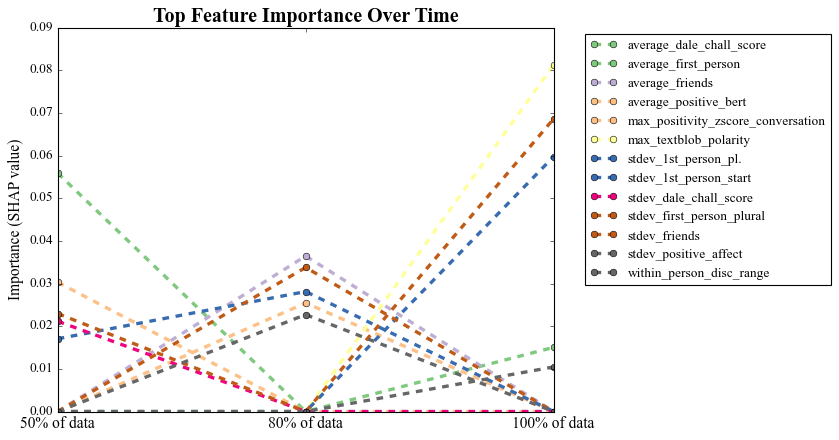

In [336]:
merged_df = pd.concat([estimation_shap_means50, estimation_shap_means80, estimation_shap_means], keys = time_points, axis=1)
plot_important_features_over_time(merged_df)

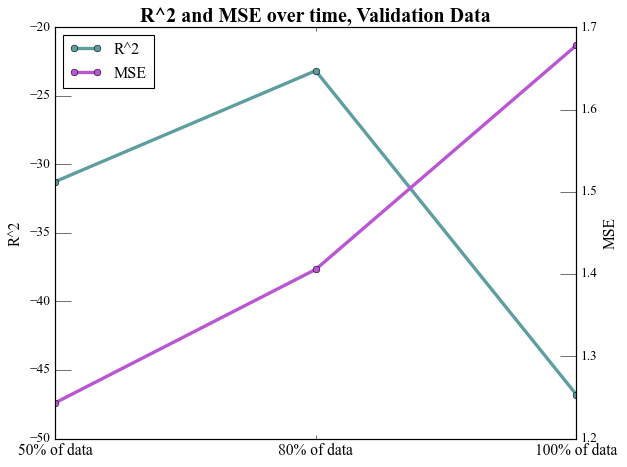

In [337]:
test_metrics = pd.concat([estimation_test_means50, estimation_test_means80, estimation_test_means], keys = time_points, axis=1)
plot_r2_and_mse_over_time(test_metrics, "R^2 and MSE over time, Validation Data")